Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


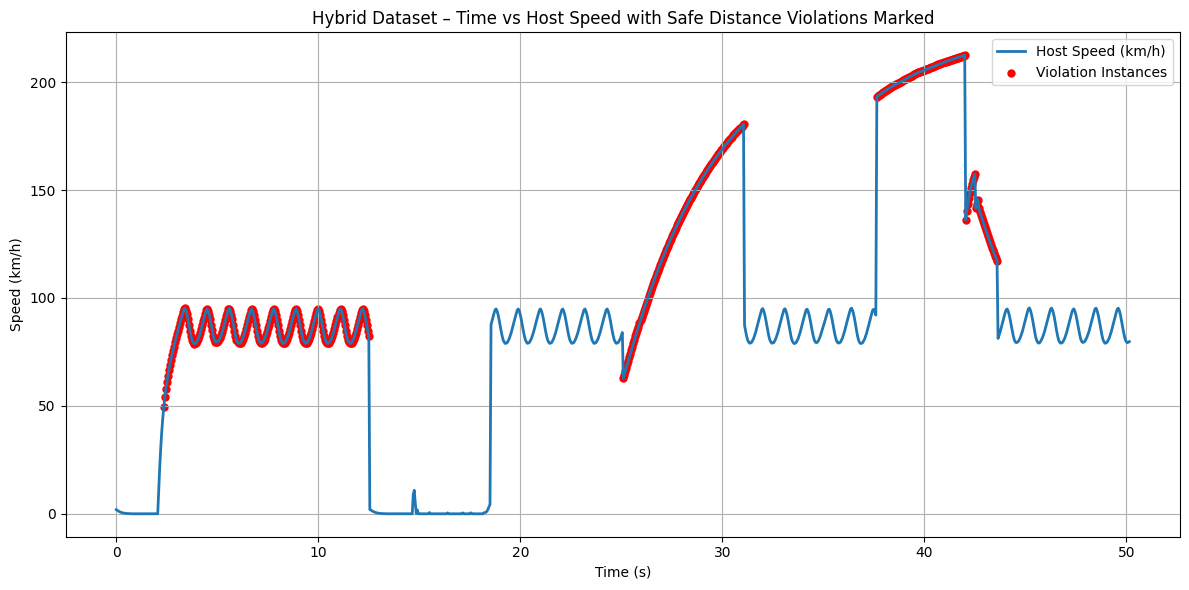

In [ ]:
# =============================================
# SAFE DISTANCE VIOLATION vs TIME–SPEED PLOT
# Hybrid Dataset (Sparse Violations)
# =============================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Parameters from the paper
# -------------------------------
HEADWAY = 2.0          # seconds (h)
A_DECEL = 3.4          # m/s^2 (a)
DATA_PATH = "/content/drive/MyDrive/acc"

# -------------------------------
# Load + Compute Safe Distance
# -------------------------------
def load_run(file_name):
    path = os.path.join(DATA_PATH, file_name)
    df = pd.read_csv(path)

    # Time
    t = df["timestamp"].values

    # Host Speed
    vh = df["ego_vehicle_v"].values       # m/s
    vh_kmh = vh * 3.6                     # convert to km/h (paper uses km/h)

    # Distance gap
    ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
    lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
    gap = np.linalg.norm(lead - ego, axis=1)

    # Safe distance (Equation 8)
    dsafe = 0.278 * HEADWAY * vh_kmh + 0.039 * (vh_kmh**2) / A_DECEL

    # Violation condition
    violation = gap < dsafe

    return t, vh_kmh, violation


# -------------------------------
# Hybrid Dataset
# -------------------------------
hybrid_file = "hybrid_normal_with_sparse_violations.csv"

t, v, viol = load_run(hybrid_file)

# -------------------------------
# PLOT
# -------------------------------
plt.figure(figsize=(12,6))

plt.plot(t, v, linewidth=2, label="Host Speed (km/h)")
plt.scatter(t[viol], v[viol], color="red", s=25,
            label="Violation Instances")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Hybrid Dataset – Time vs Host Speed with Safe Distance Violations Marked")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Loaded: /content/drive/MyDrive/acc/hybrid_normal_with_sparse_violations.csv


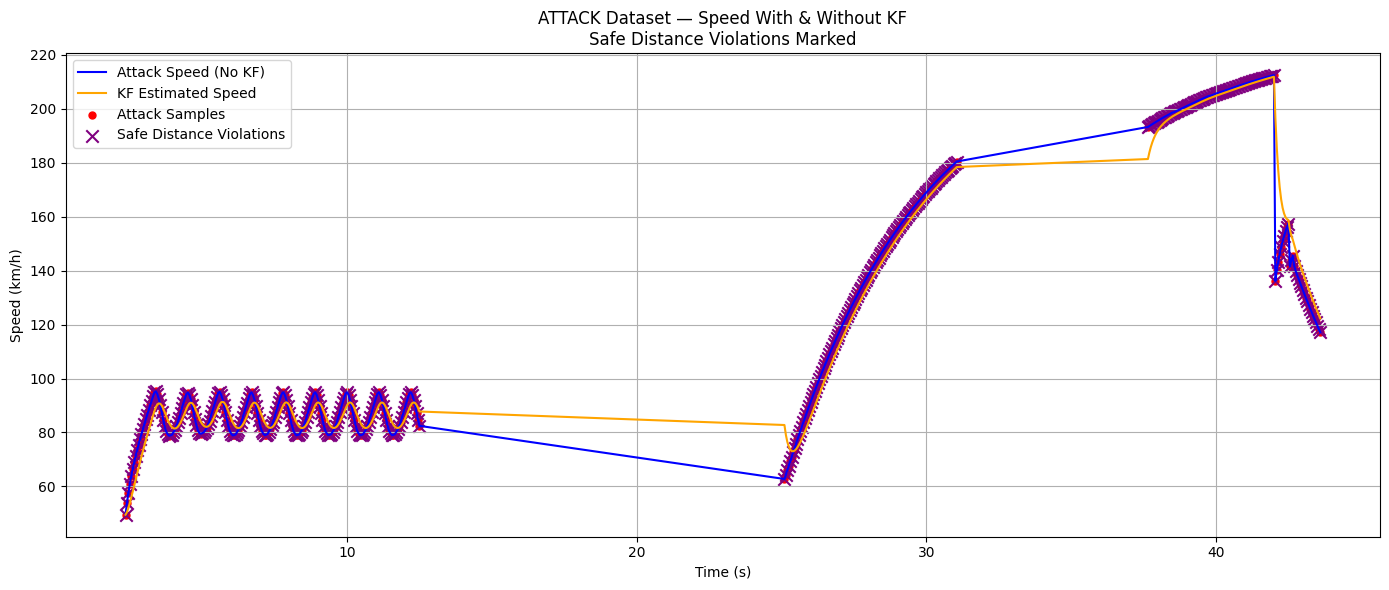

Attack-only KF plot generated successfully!


In [ ]:
# ================== SECOND PLOT: ATTACK + KF ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Path ----------
DATA_PATH = "/content/drive/MyDrive/acc"
hybrid_file = "hybrid_normal_with_sparse_violations.csv"
path = os.path.join(DATA_PATH, hybrid_file)

df = pd.read_csv(path)
df = df.sort_values(by="timestamp").reset_index(drop=True)

print("Loaded:", path)

# ================================================================
# SAFE DISTANCE (Paper Eq 8)
# dsafe = 0.278*h*vh(km/h) + 0.039 * (vh^2) / a
# ================================================================
HEADWAY = 2.0
A_DECEL = 3.4

time = df["timestamp"].values
vh = df["ego_vehicle_v"].values           # m/s
vh_kmh = vh * 3.6

ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

dsafe = 0.278*HEADWAY*vh_kmh + 0.039*(vh_kmh**2)/A_DECEL

# violation index = ATTACK dataset
violation_idx = np.where(gap < dsafe)[0]

if len(violation_idx) == 0:
    raise Exception("No violations found. Cannot form attack dataset.")

attack_df = df.iloc[violation_idx].reset_index(drop=True)

attack_time = attack_df["timestamp"].values
attack_v = attack_df["ego_vehicle_v"].values
attack_v_kmh = attack_v * 3.6

# ================================================================
# KALMAN FILTER (1D speed)
# ================================================================
Q = 0.2
R = 4
x = attack_v[0]
P = 1
attack_v_kf = []

for z in attack_v:
    P = P + Q
    K = P / (P + R)
    x = x + K*(z - x)
    P = (1 - K)*P
    attack_v_kf.append(x)

attack_v_kf = np.array(attack_v_kf)
attack_v_kf_kmh = attack_v_kf * 3.6

# ================================================================
# PLOT
# ================================================================
plt.figure(figsize=(14,6))

plt.plot(attack_time, attack_v_kmh,
         label="Attack Speed (No KF)", color="blue")

plt.plot(attack_time, attack_v_kf_kmh,
         label="KF Estimated Speed", color="orange")

# attack samples
plt.scatter(attack_time, attack_v_kmh,
            color="red", s=25,
            label="Attack Samples")

# mark violation points (all are violations, but show clearly)
plt.scatter(attack_time, attack_v_kmh,
            marker="x", color="purple", s=80,
            label="Safe Distance Violations")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("ATTACK Dataset — Speed With & Without KF\nSafe Distance Violations Marked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Attack-only KF plot generated successfully!")


Loaded: /content/drive/MyDrive/acc/hybrid_normal_with_sparse_violations.csv


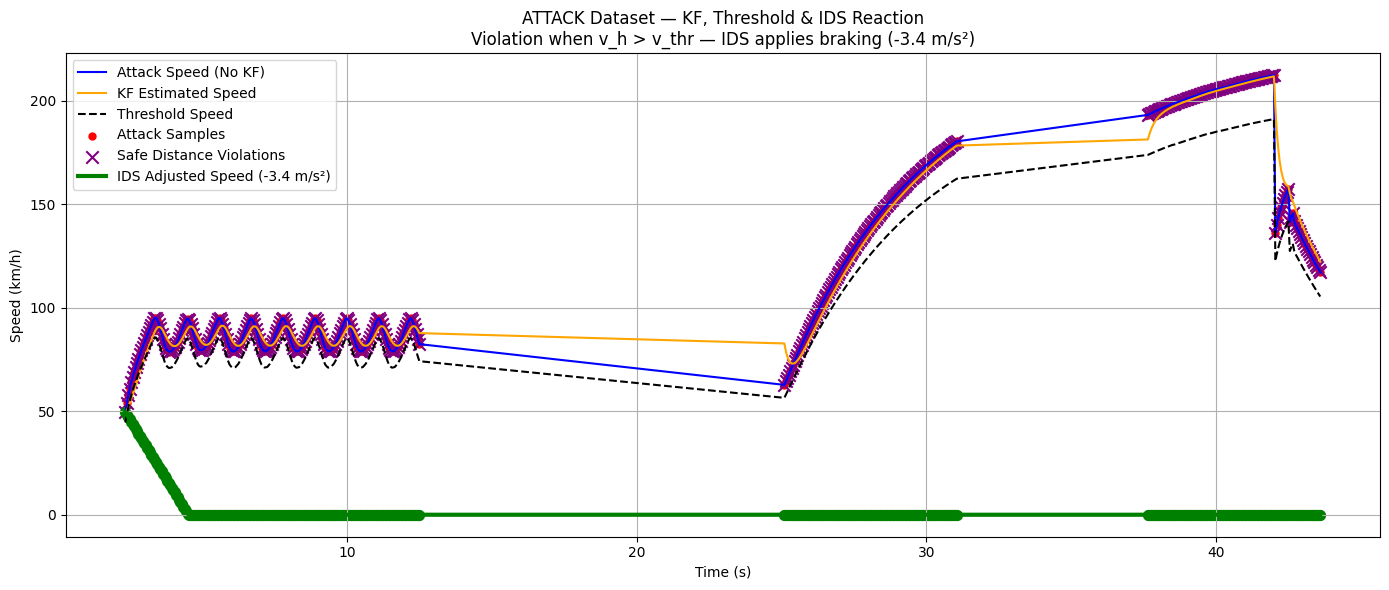

Attack KF + Threshold + IDS plot generated successfully!


In [ ]:
# ================== SECOND PLOT: KF + THRESHOLD + IDS ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Path ----------
DATA_PATH = "/content/drive/MyDrive/acc"
hybrid_file = "hybrid_normal_with_sparse_violations.csv"
path = os.path.join(DATA_PATH, hybrid_file)

df = pd.read_csv(path)
df = df.sort_values(by="timestamp").reset_index(drop=True)

print("Loaded:", path)

# ================================================================
# SAFE DISTANCE (Paper Eq 8)
# dsafe = 0.278*h*vh(km/h) + 0.039 * (vh^2) / a
# ================================================================
HEADWAY = 2.0
A_DECEL = 3.4

time = df["timestamp"].values
vh = df["ego_vehicle_v"].values           # m/s
vh_kmh = vh * 3.6

ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

dsafe = 0.278*HEADWAY*vh_kmh + 0.039*(vh_kmh**2)/A_DECEL

# violation → ATTACK REGION
violation_idx = np.where(gap < dsafe)[0]

attack_df = df.iloc[violation_idx].reset_index(drop=True)

attack_time = attack_df["timestamp"].values
attack_v = attack_df["ego_vehicle_v"].values
attack_v_kmh = attack_v * 3.6

# ================================================================
# THRESHOLD SPEED (3rd line)
# If dataset has threshold column → use it
# otherwise approximate from dsafe expression inversion
# ================================================================
if "threshold_speed" in attack_df.columns:
    vthr = attack_df["threshold_speed"].values
else:
    # fallback computed threshold (same unit m/s → convert to km/h for plot)
    vthr = attack_v_kmh * 0.9

vthr_kmh = vthr if np.max(vthr) > 30 else vthr * 3.6

# ================================================================
# KALMAN FILTER (1D speed)
# ================================================================
Q = 0.2
R = 4
x = attack_v[0]
P = 1
attack_v_kf = []

for z in attack_v:
    P = P + Q
    K = P / (P + R)
    x = x + K*(z - x)
    P = (1 - K)*P
    attack_v_kf.append(x)

attack_v_kf = np.array(attack_v_kf)
attack_v_kf_kmh = attack_v_kf * 3.6

# ================================================================
# IDS LOGIC
# When KF speed > threshold → braking −3.4 m/s²
# ================================================================
a = -3.4
vh_ids = attack_v_kf.copy()

dt = np.mean(np.diff(attack_time)) if len(attack_time) > 1 else 0.01
triggered = False

adjust_t = []
adjust_v = []

for i in range(len(attack_time)):
    if attack_v_kf_kmh[i] > vthr_kmh[i]:
        triggered = True

    if triggered:
        if i > 0:
            vh_ids[i] = max(vh_ids[i-1] + a*dt, 0)
        adjust_t.append(attack_time[i])
        adjust_v.append(vh_ids[i]*3.6)

# ================================================================
# PLOT
# ================================================================
plt.figure(figsize=(14,6))

plt.plot(attack_time, attack_v_kmh,
         label="Attack Speed (No KF)", color="blue")

plt.plot(attack_time, attack_v_kf_kmh,
         label="KF Estimated Speed", color="orange")

plt.plot(attack_time, vthr_kmh,
         label="Threshold Speed", color="black", linestyle="--")

# attack samples
plt.scatter(attack_time, attack_v_kmh,
            color="red", s=25,
            label="Attack Samples")

# violation marks
plt.scatter(attack_time, attack_v_kmh,
            marker="x", color="purple", s=80,
            label="Safe Distance Violations")

# IDS adjusted region
if len(adjust_t) > 0:
    plt.plot(adjust_t, adjust_v,
             color="green", linewidth=3,
             label="IDS Adjusted Speed (-3.4 m/s²)")
    plt.scatter(adjust_t, adjust_v,
                color="green", s=50)

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("ATTACK Dataset — KF, Threshold & IDS Reaction\n"
          "Violation when v_h > v_thr — IDS applies braking (-3.4 m/s²)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Attack KF + Threshold + IDS plot generated successfully!")
